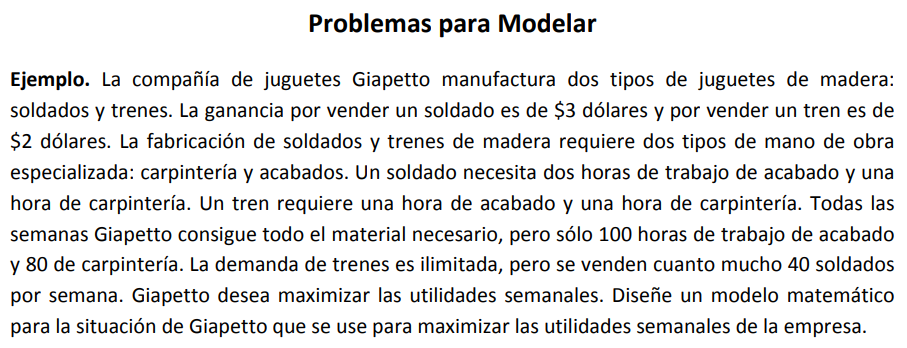

## Sets
I es el conjunto de juguetes (i = 1 son soldados, i = 2 son trenes)\
J es el conjunto de actividades (j = 1 es carpintería, j = 2 es acabado)

In [24]:
import numpy as np
import pandas as pd
import pyomo.environ as pe
import pyomo.opt as po
import itertools

In [25]:
model = pe.ConcreteModel()

In [26]:
model.I = pe.RangeSet(1,2)
model.J = pe.RangeSet(1,2)

## Parameters
D es la demanda de soldados (40 unidades semanales)\
Gi es la ganancia obtenida en USD$ del juguete i ([3,2] dólares respectivamente)\
horasij son las horas requeridas para elaborar el juguete i en la actividad j\
Hj son las horas semanales disponibles de la actividad j

In [27]:
D = 40
G = {1: 3, 2: 2}
H = {1: 80, 2: 100}
horas = {(1,1): 1, (1,2): 2,
         (2,1): 1, (2,2): 1}

In [28]:
model.D = pe.Param(initialize = D) #Demanda
model.G = pe.Param(model.I, initialize = G) #Ganancia
model.H = pe.Param(model.J, initialize = H) #Horas semanales disponibles 
model.horas = pe.Param(model.I, model.J, initialize = horas) #horas requeridas

## Variables
xi es el número de unidades a fabricar semanalmente del juguete i

In [29]:
model.x = pe.Var(model.I, domain = pe.NonNegativeReals)

## Objective

In [30]:
Z = sum(model.G[i] * model.x[i] for i in model.I)
model.objective = pe.Objective(sense = pe.maximize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 3*x[1] + 2*x[2]


## Constraints

In [31]:
model.horas_semanales = pe.ConstraintList()
for j in model.J:
    lhs = sum(model.horas[i,j] * model.x[i] for i in model.I)
    rhs = model.H[j]
    model.horas_semanales.add(lhs <= rhs)
model.horas_semanales.pprint()

horas_semanales : Size=2, Index=horas_semanales_index, Active=True
    Key : Lower : Body          : Upper : Active
      1 :  -Inf :   x[1] + x[2] :  80.0 :   True
      2 :  -Inf : 2*x[1] + x[2] : 100.0 :   True


In [32]:
restr_dem_lhs = model.x[1]
restr_dem_rhs = model.D
model.demanda = pe.Constraint(expr = (restr_dem_lhs <= restr_dem_rhs))
model.demanda.pprint()

demanda : Size=1, Index=None, Active=True
    Key  : Lower : Body : Upper : Active
    None :  -Inf : x[1] :  40.0 :   True


## Solver 

In [33]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpbj1m_8dk.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpxt9u38xg.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp_8ovjuv6.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp_8ovjuv6.pyomo.lp'...
4 rows, 3 columns, 6 non-zeros
30 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpxt9u38xg.glpk.glp'...
22 lines were written
GLPK Simplex Optimizer 5.0
4 rows, 3 columns, 6 non-zeros
Preprocessing...
2 rows, 2 columns, 4 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.000e+00  ratio =  2.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 2
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (2)
*     3: obj =   1.800000000e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb

In [34]:
for i in model.I:
    print(pe.value(model.x[i]))
print(pe.value(model.objective))

20.0
60.0
180.0
